# 2. Phát hiện biên Canny

Chúng ta sẽ phát hiện biên sử dụng phương pháp Canny với các bước:
- Làm mìn ảnh bằng lọc Gaussian
- Tính độ lớn và hướng của Gradient bằng Sobel
- Loại bỏ những giá trị không phải cực đại
- Phân ngưỡng kép để xác định biên

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def scale_to_0_255(img): # normalize lại giá trị các pixel sao về (0,1)
    min_val = np.min(img)
    max_val = np.max(img)
    new_img = (img - min_val) / (max_val - min_val) # 0-1
    new_img *= 255
    return new_img

# phương pháp canny
def my_canny(img, min_val, max_val, sobel_size=3, is_L2_gradient=False):
    """
    implement Canny algorithm in OpenCV tutorial @ https://docs.opencv.org/master/da/d22/tutorial_py_canny.html
    """
    
    #2. Noise Reduction (giảm nhiễu hay làm mịn ảnh, ta dùng bộ lọc 
    # Gaussian kernel 5x5). lưu ý kernel càng lớn thì độ nhạy cảm 
    # với nhiễu càng giảm
    smooth_img = cv2.GaussianBlur(img, ksize=(5, 5), sigmaX=1, sigmaY=1)
    
    #3. Finding Intensity Gradient of the Image (sử dụng toán tử sobel đã học)
    Gx = cv2.Sobel(smooth_img, cv2.CV_64F, 1, 0, ksize=sobel_size)
    Gy = cv2.Sobel(smooth_img, cv2.CV_64F, 0, 1, ksize=sobel_size)
    
    # tính độ lớn (Theo cô Thảo ta chỉ sử dụng giá trị tuyệt đối nhưng ta hãy thử
    # sử dụng khoảng cách Euclid)
    if is_L2_gradient:
        edge_gradient = np.sqrt(Gx*Gx + Gy*Gy)
    else:
        edge_gradient = np.abs(Gx) + np.abs(Gy)
    
    angle = np.arctan2(Gy, Gx) * 180 / np.pi
    
    # round angle to 4 directions # đơn giản chỉ là làm tròn theo 4 hướng
    angle = np.abs(angle)
    angle[angle <= 22.5] = 0
    angle[angle >= 157.5] = 0
    angle[(angle > 22.5) * (angle < 67.5)] = 45
    angle[(angle >= 67.5) * (angle <= 112.5)] = 90
    angle[(angle > 112.5) * (angle <= 157.5)] = 135
    
    #4. Non-maximum Suppression (loại bỏ những giá không phải cực đại)
    keep_mask = np.zeros(smooth_img.shape, np.uint8)
    for y in range(1, edge_gradient.shape[0]-1):
        for x in range(1, edge_gradient.shape[1]-1):
            area_grad_intensity = edge_gradient[y-1:y+2, x-1:x+2] # 3x3 area
            area_angle = angle[y-1:y+2, x-1:x+2] # 3x3 area
            current_angle = area_angle[1,1]
            current_grad_intensity = area_grad_intensity[1,1]
            
            if current_angle == 0:
                if current_grad_intensity > max(area_grad_intensity[1,0], area_grad_intensity[1,2]):
                    keep_mask[y,x] = 255
                else:
                    edge_gradient[y,x] = 0
            elif current_angle == 45:
                if current_grad_intensity > max(area_grad_intensity[2,0], area_grad_intensity[0,2]):
                    keep_mask[y,x] = 255
                else:
                    edge_gradient[y,x] = 0
            elif current_angle == 90:
                if current_grad_intensity > max(area_grad_intensity[0,1], area_grad_intensity[2,1]):
                    keep_mask[y,x] = 255
                else:
                    edge_gradient[y,x] = 0
            elif current_angle == 135:
                if current_grad_intensity > max(area_grad_intensity[0,0], area_grad_intensity[2,2]):
                    keep_mask[y,x] = 255
                else:
                    edge_gradient[y,x] = 0
    
    #5. Hysteresis Thresholding (Phân ngưỡng kép)
    canny_mask = np.zeros(smooth_img.shape, np.uint8)
    canny_mask[(keep_mask>0) * (edge_gradient>min_val)] = 255
    
    return scale_to_0_255(canny_mask)

img = cv2.imread('lenna.png', 0)
my_canny = my_canny(img, min_val=100, max_val=200)
edges = cv2.Canny(img, 100, 200)

cv2.imwrite('my_canny.jpg', my_canny)
cv2.imwrite('edges.jpg', edges)

True

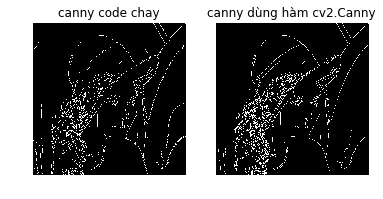

In [3]:
img1 = cv2.imread('my_canny.jpg')
img2 = cv2.imread('edges.jpg')

plt.subplot(121)
plt.axis('off')
plt.title('canny code chay')
plt.imshow(img1)

plt.subplot(122)
plt.axis('off')
plt.title('canny dùng hàm cv2.Canny')
plt.imshow(img2)

plt.show()

Với kết quả trên, ta rút ra được rằng Canny không hoạt động tốt với những bức ảnh có mức độ chi tiết cao khi mà những chi tiết không phải nó có thể coi là biên. Tỉ lệ lỗi thấp. vị trí các biên rất gần, gần như trùng với biên gốc.